<a href="https://colab.research.google.com/github/ItshMoh/Audio_Detection/blob/main/federated_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 41.1 M

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
from torchvision.datasets import MNIST

In [ ]:
import flwr as fl
from flwr.common import Metrics

In [ ]:
Classes= (
    'ZERO',
    'ONE',
    'TWO',
    'THREE',
    'FOUR',
    'FIVE',
    'SIX',
    'SEVEN',
    'EIGHT',
    'NINE',

)

In [ ]:
no_of_clients=108

In [ ]:
BATCH_SIZE = 32
no_of_clients=108

def load_datasets():

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset=MNIST("./dataset",download=True,train=True,transform=transform)
    test_dataset=MNIST("./dataset",download=True,train=False,transform=transform)

    partition_size = len(train_dataset) // no_of_clients
    remainder = len(train_dataset) % no_of_clients
    lengths = [partition_size] * no_of_clients
    for i in range(remainder):
        lengths[i] += 1

    datasets = random_split(train_dataset, lengths, torch.Generator().manual_seed(42))

    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()


100%|██████████| 9912422/9912422 [00:00<00:00, 120900042.88it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76474554.18it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44728021.40it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14366914.61it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



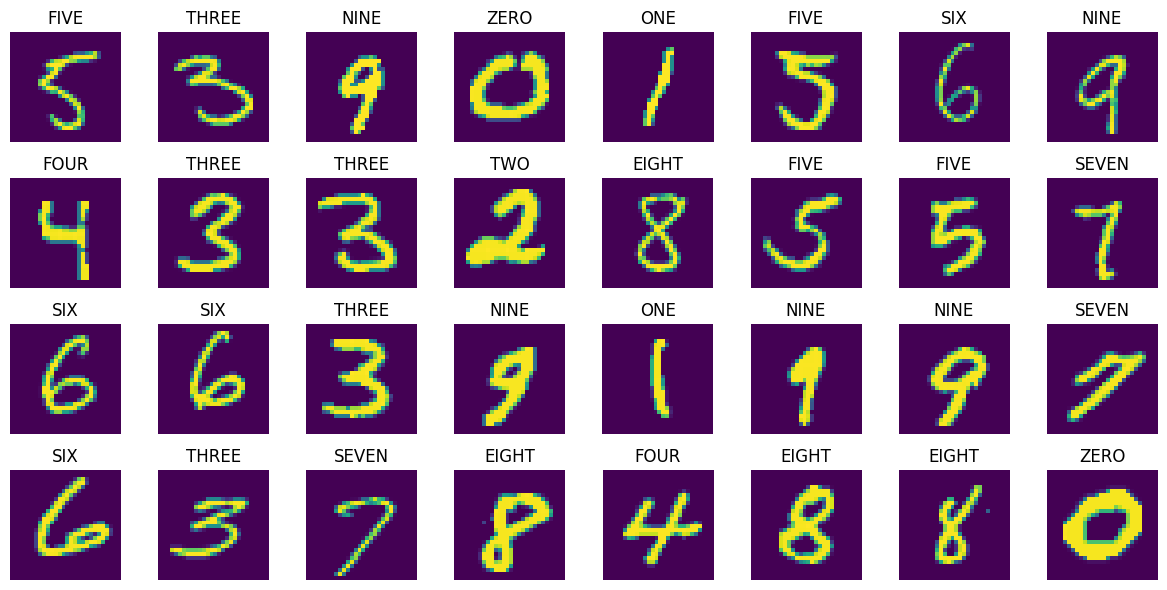

In [ ]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(Classes[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16* 4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
DEVICE = torch.device("cpu")

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)


for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.08025504892522639, accuracy 0.38181818181818183
Epoch 2: validation loss 0.06315272071144798, accuracy 0.4727272727272727
Epoch 3: validation loss 0.03835756778717041, accuracy 0.7272727272727273
Epoch 4: validation loss 0.029160742326216266, accuracy 0.7272727272727273
Epoch 5: validation loss 0.024366581439971925, accuracy 0.7818181818181819
Final test set performance:
	loss 0.022079178203642368
	accuracy 0.784


In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # Sample 100% of available clients for training
    fraction_evaluate=0.25,  # Sample 50% of available clients for evaluation
    min_fit_clients=8,  # Never sample less than 10 clients for training
    min_evaluate_clients=20,  # Never sample less than 5 clients for evaluation
    min_available_clients=no_of_clients,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None


# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=no_of_clients,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-08 02:06:56,782 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-09-08 02:06:59,967	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-08 02:07:02,741 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7794627380.0, 'object_store_memory': 3897313689.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7794627380.0, 'object_store_memory': 3897313689.0}
INFO flwr 2023-09-08 02:07:02,749 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-08 02:07:02,761 | app.py:224 | Flower VCE: Resources for each Virtual Clie

History (loss, distributed):
	round 1: 0.08146388683254874
	round 2: 0.06756534945683848
	round 3: 0.04497039530815098
	round 4: 0.029843652288520376
	round 5: 0.02219818724124921

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,
    fraction_evaluate=0.25,
    min_fit_clients=8,
    min_evaluate_clients=20,
    min_available_clients=no_of_clients,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=no_of_clients,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

WARNING flwr 2023-09-05 06:17:29,292 | fedavg.py:117 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-05 06:17:29,304 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
Exception in thread Thread-40:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", li

History (loss, distributed):
	round 1: 0.08013980083594016
	round 2: 0.06124755625772958
	round 3: 0.038264066322082624
	round 4: 0.028340183474399417
	round 5: 0.02226828107930193
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.464983164983165), (2, 0.6208754208754209), (3, 0.75993265993266), (4, 0.7878787878787877), (5, 0.8410774410774409)]}